- [x] try just one predictor
    - [ ] multi input, single output
- [x] comparem ulti
- losses:
    - try logp? nah
    - mae?
- [x] make my own csv with 5m data (maybe 10k rows)
- [ ] backtest?

In [1]:
import warnings
warnings.simplefilter("ignore")

# autoreload import your package
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join
import math
import logging
from typing import Callable, Optional, Union, Dict, Tuple

from matplotlib import pyplot as plt
from pathlib import Path
import matplotlib.colors as mcolors

import gin
from fire import Fire
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import optim
from torch import nn

from experiments.base import Experiment
from data.datasets import ForecastDataset
from models import get_model
from utils.checkpoint import Checkpoint
from utils.ops import default_device, to_tensor
from utils.losses import get_loss_fn
from utils.metrics import calc_metrics

from experiments.forecast import get_data
gin.enter_interactive_mode()

# auto

In [11]:


def plot(model_name="deeptime", save_path=Path("storage/experiments/Exchange/96M/repeat=0"), i=200, title=None, plot=True):

    gin.clear_config()
    gin.parse_config(open(save_path/"config.gin"))

    train_set, train_loader = get_data(flag='train', batch_size=2)

    model = get_model(model_name,
                        dim_size=train_set.data_x.shape[1],
                        datetime_feats=train_set.timestamps.shape[-1]).to(default_device())
    model.load_state_dict(torch.load(save_path/'model.pth'))
    model = model.eval()


    b = train_set[i]
    b = [bb[None, :] for bb in b]
    b2 = list(map(to_tensor, b))
    context_past_x, context_y, query_past_x, query_y, context_time, query_time = b2
    with torch.no_grad():
        forecast = model(*b2)

    if title is None:
        title = str(save_path).split('/')[-3:]
        title = "-".join(title)
    
    colors = list(mcolors.BASE_COLORS.keys())
    l = x.shape[1]
    forecast2 = forecast[0].detach().cpu().numpy()
    x2 = x[0].cpu()
    y2 = y[0].cpu()
    l2 = y.shape[1]
    i_past = list(range(l))
    i_future = list(range(l, l+l2))
    
    if plot:
        plt.title(title)
        for i in range(x.shape[-1]):
            plt.plot(i_past, x2[:, i], c=colors[i])
        for i in range(x.shape[-1]):
            plt.plot(i_future, y2[:, i], c=colors[i])
        for i in range(x.shape[-1]):
            plt.plot(i_future, forecast2[:, i], c=colors[i], linestyle='--')
    return x2, y2, forecast2, i_past, i_future


In [22]:


def plot_multi(save_paths=[Path("storage/experiments/Exchange/96M/repeat=0")], i=200, title=None, plot=True):
    for j in range(len(save_paths)):
        save_path = save_paths[j]

        gin.clear_config()
        gin.parse_config(open(save_path/"config.gin"))
        model_name = gin.query_parameter("instance.model_type")

        train_set, train_loader = get_data(flag='test', batch_size=3)

        model = get_model(model_name,
                            dim_size=train_set.data_x.shape[1],
                            datetime_feats=train_set.timestamps.shape[-1]).to(default_device())
        model.load_state_dict(torch.load(save_path/'model.pth'))
        model = model.eval()


        b = train_set[i]
        b = [bb[None, :] for bb in b]
        b2 = list(map(to_tensor, b))
        
#         b = next(iter(train_loader))
#         print([s.shape for s in b])
        
        context_past_x, context_y, query_past_x, query_y, context_time, query_time = b2
        with torch.no_grad():
            forecast = model(*b2)
       
        colors = list(mcolors.BASE_COLORS.keys())
        l = context_time.shape[1]
        forecast2 = forecast[0].detach().cpu().numpy()
        x2 = context_y[0].cpu()
        y2 = query_y[0].cpu()
        l2 = query_time.shape[1]
        i_past = list(range(l))
        i_future = list(range(l, l+l2))

        if plot:
            plt.plot(i_past, x2[:, 0], c=colors[0], label=f"past")
            plt.plot(i_future, y2[:, 0], c=colors[0], label="future true", alpha=0.3)
            
            mtitle = str(save_path).split('/')[-2:-1]
            mtitle = "-".join(mtitle)
            plt.plot(i_future, forecast2[:, 0], c=colors[j], linestyle='--', label=f"{mtitle}")
    plt.legend()
    plt.title(title)
    return x2, y2, forecast2, i_past, i_future


In [19]:
# list the models we have run...
m=sorted(Path("storage/experiments/Stocks").glob("**/_SUCCESS"))
print(m)

[Path('storage/experiments/Stocks/96M/repeat=0/_SUCCESS'), Path('storage/experiments/Stocks/96M2S/repeat=0/_SUCCESS'), Path('storage/experiments/Stocks/96S/repeat=0/_SUCCESS'), Path('storage/experiments/Stocks/96Splus/repeat=0/_SUCCESS'), Path('storage/experiments/Stocks/96Splusshort/repeat=0/_SUCCESS'), Path('storage/experiments/Stocks/96Sshort/repeat=0/_SUCCESS')]


In [14]:
save_path = Path('storage/experiments/Stocks/96M2S/repeat=0')

In [15]:
gin.clear_config()
config_path = save_path/"config.gin"
gin.parse_config(open(config_path))
model_name = gin.query_parameter("instance.model_type")
model_name

'deeptime3'

In [16]:
from experiments.forecast import ForecastExperiment
exp = ForecastExperiment(config_path=config_path)
exp

In [20]:
# exp.run()

receptive field [114 342 362]=[38 18  2]*[[  1   1   1]
 [  1   6  36]
 [  1  12 144]]
receptive field [690 378 242]=[138  18   2]*[[ 1  1  1]
 [ 1  2  4]
 [ 1  4 16]
 [ 1  6 36]
 [ 1  8 64]]


1

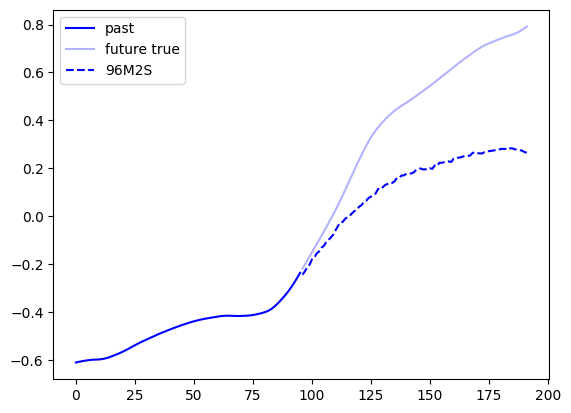

In [29]:
plot_multi(
    save_paths=[
        save_path,
#         Path('storage/experiments/Stocks/96M/repeat=0'),
               ],
    i=100,
)
1